# **Régression linéaire simple**

## **Importation des bibliothèques**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Pour les traîtements sur les variables
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Modèle de ML utilisé
from sklearn.linear_model import LinearRegression

# Pour gridsearch
from sklearn import model_selection

from sklearn import metrics

## **Importation du dataset**

In [2]:
dataset_a_utiliser = "data_clean.xlsx"

data = pd.read_excel(dataset_a_utiliser)
print('Importation terminée')

Importation terminée


## **Split & Scale**

In [3]:
######################
# Choix des features #
######################

features_list = [
                 'BuildingType',
                 'PrimaryPropertyType',
                 'Neighborhood',
                 'YearBuilt',
                 'NumberofBuildings',
                 'NumberofFloors',
                 'PropertyGFAParking',
                 'PropertyGFABuilding(s)'
                ]

y_column = 'SiteEnergyUseWN_kBtu'
#y_column = 'TotalGHGEmissions'

###############################
# Split du dataset par X et y #
###############################

X = data.loc[:,features_list] # On ajoute nos features dans le X
y = data.loc[:,y_column] # On ajoute ce qu'on veut prédire dans le y


#####################################################################
# Scaling des données quantitatives et qualitatives (si existantes) #
# Je fais le scale ici car il y a des 'YearBuilt' uniques (ex 1939) #
# et du coup je ne pourrai pas faire un transform sur X_test        #
#####################################################################

categorical_features = [
                        'BuildingType',
                        'PrimaryPropertyType',
                        'Neighborhood',
                        'YearBuilt'
                       ]

numeric_features = [
                    'NumberofBuildings',
                    'NumberofFloors',
                    'PropertyGFAParking',
                    'PropertyGFABuilding(s)'
                   ]

numeric_transformer = StandardScaler()

categorical_transformer = OneHotEncoder()

feature_encoder = ColumnTransformer(
            transformers=[
                ('cat', categorical_transformer, categorical_features),    
                ('num', numeric_transformer, numeric_features)
                ]
            )
X = feature_encoder.fit_transform(X)


#####################################
# Split du dataset en train et test #
#####################################

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=0
                                                    )
                                                    #stratify=y) # : Stratification du sample. 
                                                    # Il y aura alors la même proportion
                                                    # de catégories dans les sets de test et train.
                                                    # Utile surtout s'il y a peu de lignes dans le dataset.
                                                    # Peut causer une erreur si certaines catégories n'ont pas assez de représentants


print("Split & Scale : OK")

Split & Scale : OK


## **Entraînement du modèle**

In [4]:
modele = LinearRegression()
modele.fit(X_train, y_train) # Étape d'entraînement
print("Entraînement : OK")

Entraînement : OK


## **Score du modèle**

In [5]:
print(f"Le score R² du modèle est de {modele.score(X_train, y_train):.3f} (train) et {modele.score(X_test, y_test):.3f} (test).")

Le score R² du modèle est de 0.695 (train) et 0.642 (test).


## **GridSearch**

Test des meilleurs hyperparamètres. Dans le cadre d'une régression linéraire simple, pas grand chose à tester.

In [6]:
###############################################
# Paramétrage de GridSearchCV et entraînement #
###############################################

# Fixer les valeurs des hyperparamètres à tester
param_grid = {'fit_intercept':[True, False]}

# Déterminer le score qu'on veut optimiser
score = 'r2'

# Je le sors ici car je vais réutiliser cette valeur plus tard
cv = 5

grid = model_selection.GridSearchCV(
    LinearRegression(), # On indique le modèle à tester
    param_grid,     # hyperparamètres à tester
    cv=cv,           # nombre de folds de validation croisée
    scoring=score   # score à optimiser
)

# Optimiser ce modèle sur le jeu d'entraînement
grid.fit(X_train, y_train)

###########################
# Affichage des résultats #
###########################

# Afficher le(s) hyperparamètre(s) optimaux
print(f"Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement : {grid.best_params_}\n")

# Afficher les performances correspondantes
print('Résultats pour chaque fold :')
for i in range(cv):
    print(f"Fold n°{i+1} :", eval(f"grid.cv_results_['split{i}_test_score']"), f"(Pour les paramètres : {grid.cv_results_['params']})")

print("\nRésultats de la validation croisée :")
for mean, std, params in zip(
        grid.cv_results_['mean_test_score'], # score moyen
        grid.cv_results_['std_test_score'],  # écart-type du score
        grid.cv_results_['params']           # valeur de l'hyperparamètre
    ):

    print(f"{score} (moyen) : {mean:.04f} (+/-{std*2:.04f}) pour {params}")

###################################################################
# Prédiction sur le jeu de test avec les hyperparamètres optimaux #
###################################################################

# GridSearchCV a automatiquement ré-entraîné le meilleur modèle sur l’intégralité du jeu d’entraînement.
y_pred = grid.predict(X_test)
print(f"\nScore sur le jeu de test (avec paramètres optimaux): {metrics.r2_score(y_test, y_pred):.3f}")



Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement : {'fit_intercept': False}

Résultats pour chaque fold :
Fold n°1 : [0.34471381 0.34471409] (Pour les paramètres : [{'fit_intercept': True}, {'fit_intercept': False}])
Fold n°2 : [0.52498358 0.52490865] (Pour les paramètres : [{'fit_intercept': True}, {'fit_intercept': False}])
Fold n°3 : [0.52523082 0.52528681] (Pour les paramètres : [{'fit_intercept': True}, {'fit_intercept': False}])
Fold n°4 : [0.62765514 0.62765585] (Pour les paramètres : [{'fit_intercept': True}, {'fit_intercept': False}])
Fold n°5 : [0.67282956 0.67287457] (Pour les paramètres : [{'fit_intercept': True}, {'fit_intercept': False}])

Résultats de la validation croisée :
r2 (moyen) : 0.5391 (+/-0.2261) pour {'fit_intercept': True}
r2 (moyen) : 0.5391 (+/-0.2261) pour {'fit_intercept': False}

Score sur le jeu de test (avec paramètres optimaux): 0.642


## **Importance des features**

,Features,coefficients
0,Campus,2.724704e+06
1,NonResidential,2.973343e+05
2,Nonresidential COS,-1.149570e+06
3,SPS-District K-12,-1.872467e+06
4,Distribution Center,-4.023268e+06
...,...,...
149,2015,-9.457827e+05
150,NumberofBuildings,1.181455e+06
151,NumberofFloors,1.044350e+06
152,PropertyGFAParking,9.629161e+05


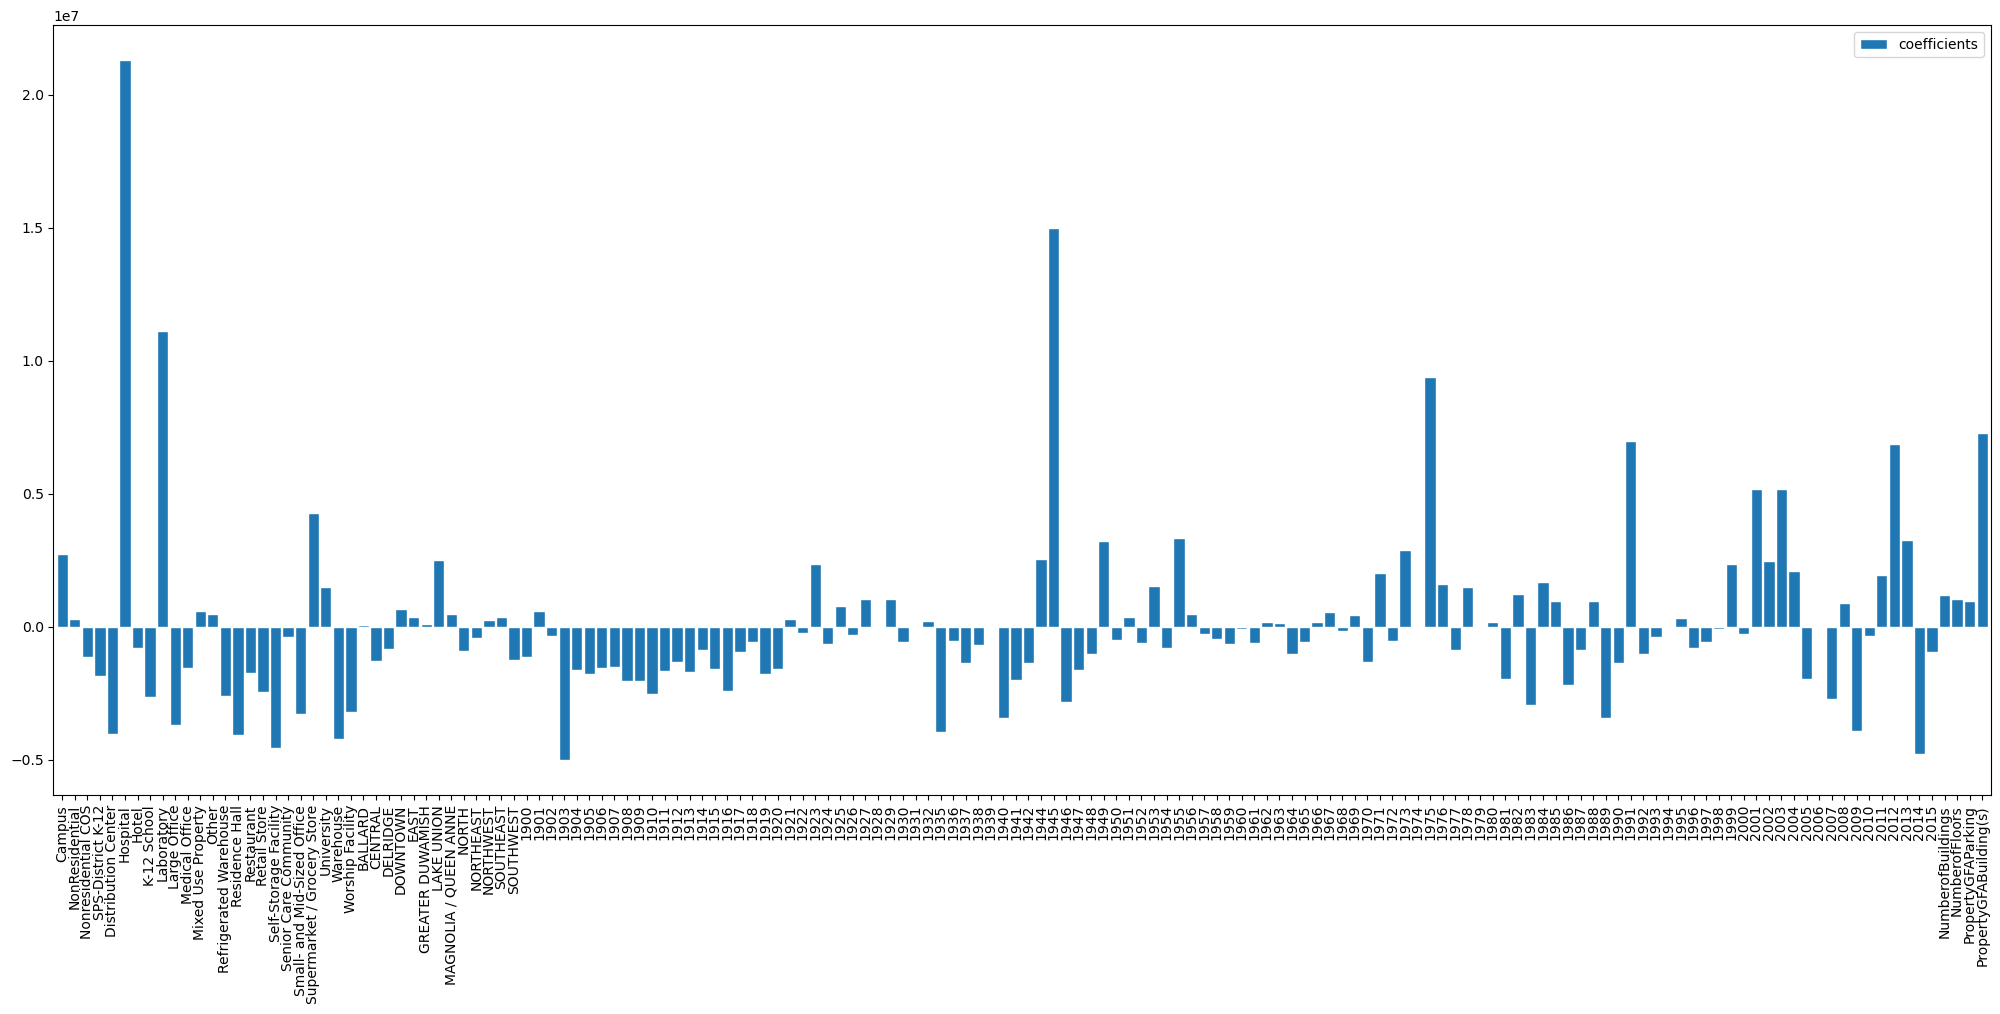

In [7]:
# Si on n'a pas utilisé de features catégorielles, alors on va mettre categories_names_concat à []
if categorical_features == []:
    categories_names_concat = []
# Sinon, on fait la procédure habituelle
else:
    categories_names = feature_encoder.transformers_[0][1].categories_
    # "feature_encoder.transformers_" est une liste de tuples, un tuple par transformer.
    # On obtient le transformer de catégorie qui est OneHotEncoder() avec [0][1] (2 ème élément du premier tuple de la liste).
    # On ajoute ".categories_" pour voir les catégories traitées par ce transformer.
    
    # On passe par cette double boucle pour éviter les erreurs s'il y a plusieurs colonnes de valeurs catégorielles,
    # et que donc "feature_encoder.transformers_[0][1].categories_" retourne une liste d'arrays (un par colonne),
    # qui eux-mêmes contiennent des listes (de chaque catégories présentes dans la colonne)
    """categories_names_concat = []
    for i in categories_names:
        for j in i.tolist():
            categories_names_concat.append(j)"""

    # Méthode plus rapide avec une liste en intention : 
    categories_names_concat = [item for array in categories_names for item in array]

numerical_column_names = ['NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)']



# On regroupe ici toutes les catégories et le nom des colonnes numériques
# np.append() va retourner un array avec une liste dedans

all_features_names = np.append(categories_names_concat, numerical_column_names)


# On créé le dataframe feature_importance avec en première colonne tous les éléments de all_features_names,
# et en deuxième colonne les coefficients obtenus avec le machine learning.
# Ce dataframe nous servira pour la représentation graphique de nos résultats



# On adapte la synthaxe en fonction du modèle utilisé.
if type(modele) == type(LinearRegression()):
    coef_modele = modele.coef_
else:
    coef_modele = modele.feature_importances_


feature_importance = pd.DataFrame({
    "Features": all_features_names,
    "coefficients": coef_modele
})

# Les coefficients peuvent être positifs ou négatifs, ce qui nous intéresse pour le moment est leur valeur absolue.
#feature_importance["coefficients"] = feature_importance["coefficients"].abs()

display(feature_importance)
feature_importance.plot(x='Features', y='coefficients', kind="bar", width=0.9, linewidth=1, edgecolor = "white", figsize = (25, 10)).set(xlabel=None);